In [1]:
!pip install --upgrade summa
!pip install --upgrade nltk #3.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=dce48dd12a9b9bd63c70c25e7b989f1da392c44b852b3d565f3408d7bfbb983b
  Stored in directory: /root/.cache/pip/wheels/70/26/84/58df5a55ebde6fd802666b6ac0b86909ecd018a2702b89d13c
Successfully built summa
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1


In [2]:
from importlib.metadata import version
import nltk
import torch
import summa
import pandas as pd

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.8.0+cu126
2.2.2
1.2.0


# 1. 데이터 수집

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
None


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# 2. 전처리

In [5]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import torch
from collections import Counter

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2.1. 중복 데이터 & 결측치 처리

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# null 존재 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 2.2. 텍스트 정규화, 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

NLTK를 이용해 불용어를 제거하는 파트는 text 전처리에서만 사용할 것이다.  
headline에는 불용어가 남아 있어야 자연스러운 문장이 되기 때문이다.

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"', '', sentence) # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전처리 전/후 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headline, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


모두 소문자로 변환, 특수문자 제거 등 전처리가 잘 진행되는 것을 확인했으니,
이제 학습 데이터 전체에 대해 전처리를 수행하자.

In [13]:
clean_text = []

for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

clean_headlines = []

for sentence in data['headlines']:
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords=False))

print("text 전처리 후 결과: ", clean_text[:5])
print("headline 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
# 전처리 후 모든 텍스트가 사라졌는지 확인
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

,0
headlines,0
text,0


# 3. train, test 나누기

## 3.1. 샘플의 최대 길이 지정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


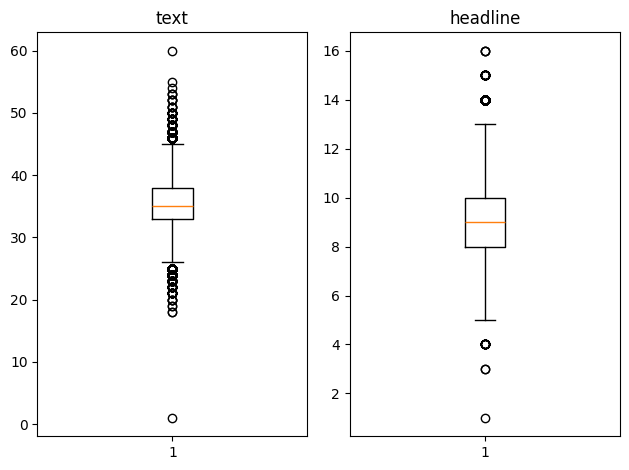

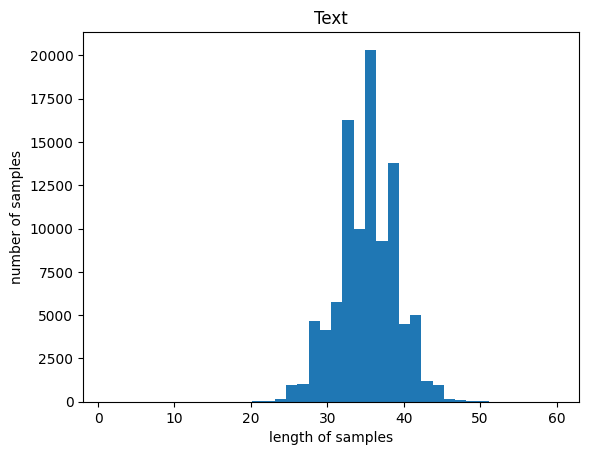

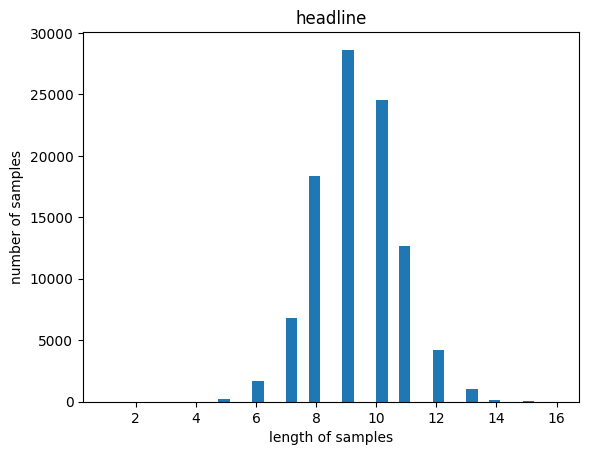

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 두 열의 최대 길이를 임의로 정해보면
text_max_len = 40
headlines_max_len = 10

In [17]:
# 위의 길이로 잘리는 샘플이 총 데이터의 몇 %에 해당하는지 계산해보자
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [18]:
# 정해진 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


## 3.2. 시작/종료 토큰 추가

In [19]:
# headlines 데이터에는 시작/종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [20]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 넘파이 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 3.3. train, test

In [21]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# indices를 이용해 순서 다시 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 테스트 데이터셋 크기 정의
n_of_val = int(len(encoder_input)*0.2)

# 데이터셋 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


# 4. 정수 인코딩

In [22]:
# vocab 만들기
def src_tokenizer(text): # 토크나이저 정의
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다.
그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외할 것.

In [23]:
threshold = 7

# 전처리된 데이터 사용
text_data = data['text'].tolist()
headlines_data = data['headlines'].tolist()

# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67472
등장 빈도가 6번 이하인 희귀 단어의 수: 45997
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21475
단어 집합에서 희귀 단어의 비율: 68.17198245198009
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.636634721442695


vocab에서 희귀 단어의 비율은 68%지만 전체 데이터에서의 비율은 3.6% 뿐이다.
vocab의 크기를 21000으로 제한하고 희귀 단어들은 삭제.

In [24]:
src_vocab_size = 22000

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [25]:
# 생성된 vocab에 기반하여 input text의 단어들을 모두 정수로 변환하는 인코딩 수행
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[1400, 380, 1021, 608, 57, 704, 2289, 250, 143, 1336, 10, 236, 153, 63, 1, 676, 7643, 608, 2, 250, 1818, 1243, 1400, 6644, 230, 1430, 612, 4652], [7644, 24, 1, 5588, 3, 1471, 6748, 3288, 1819, 761, 3288, 3288, 1318, 131, 9760, 939, 809, 425, 1319, 2096, 1471, 131, 9760, 3442, 20982, 4286, 2317, 4786, 601, 510, 4326, 116, 3085], [366, 1080, 96, 3021, 560, 2521, 4737, 167, 915, 12616, 13189, 9761, 6, 1, 11, 30, 7401, 3601, 110, 26, 194, 9762, 4737, 3601, 345, 3261, 5898, 3165, 1, 96, 2521, 17942, 2881]]
[[1589, 290, 1, 47, 3966, 1, 1148, 395, 29, 711, 488, 17382, 3976, 239, 13021, 2283, 488, 72, 101, 1313, 290, 85, 2240, 725, 587, 3966, 8052, 488, 713, 30, 19037, 3818, 284, 543, 19291, 1276, 85, 1275, 4731, 18853], [176, 15, 144, 71, 850, 14, 130, 286, 141, 536, 2004, 23, 102, 4130, 8548, 920, 38, 133, 1, 488, 37, 17, 130, 2004, 76, 71, 61, 536, 76, 71, 315, 101, 850, 23, 102, 130], [266, 171, 1317, 1177, 358, 6810, 19, 1578, 5639, 227, 9498, 2463, 20894, 4006, 871, 1561, 1764, 97, 2495

In [26]:
# headlines도 동일하게 수행

def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27284
등장 빈도가 5번 이하인 희귀 단어의 수: 18203
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9081
단어 집합에서 희귀 단어의 비율: 66.71675707374285
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.934429435895501


In [27]:
tar_vocab_size = 10000
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 698, 568, 2257, 13, 112, 62, 5, 5206, 682], [2, 2514, 7, 100, 8, 1, 480, 4502, 8, 335], [2, 585, 4, 1, 34, 1, 7, 7132, 88], [2, 871, 1380, 10, 626, 2948, 9290, 2043, 5, 860], [2, 2068, 1, 7802, 1561, 449, 108, 2093]]
target
decoder  [[698, 568, 2257, 13, 112, 62, 5, 5206, 682, 3], [2514, 7, 100, 8, 1, 480, 4502, 8, 335, 3], [585, 4, 1, 34, 1, 7, 7132, 88, 3], [871, 1380, 10, 626, 2948, 9290, 2043, 5, 860, 3], [2068, 1, 7802, 1561, 449, 108, 2093, 3]]


이제 인코딩은 완료했고, 패딩 해야한다.
근데 위에서 빈도수 낮은 단어를 삭제했는데, 그럼 이 삭제된 단어들로만 이루어진 샘플들은 빈 칸이 되었을 것이다.
특히 평균길이가 4밖에 안 되는 summary는 많이 비어있을 수도 있다.
확인해보자.

다만, 위에서 decoder_input에는 sos, decoder_target에는 eos 토큰이 추가된 상태이고, 얘네는 빈도수가 매우 많으므로 삭제되지 않고 남아있을 것이다. 즉, decoder_input에는 sos, decoder_target에는 eos만 남아있을 것.

그래서 실제로는 summary에 빈 샘플이 없고 길이가 1일 것이다.

In [28]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


라고 생각해서 실행했는데, 0개가 나옴.  
sostoken이나 eostoken을 직접 찾아서 해당 문자만 포함되어있는 데이터는 삭제하는 방향으로 해결을 시도했지만 실패.

## 4.2. 패딩

In [29]:
from torch.nn.utils.rnn import pad_sequence

# 텐서 변환 함수 (리스트 → PyTorch 텐서)
def convert_to_tensor(sequences):
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수 (PyTorch `pad_sequence()` 활용)
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=padding_value)  # 패딩 적용
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=headlines_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=headlines_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=headlines_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=headlines_max_len)

# 5. 모델 설계

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
src_vocab_size = len(src_vocab)  # 단어 집합 크기

# 인코더
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers,
            dropout=dropout, batch_first=True
        )

    def forward(self, x): # 인코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # LSTM 실행
        return output, hidden, cell

# 인코더 모델 생성 (num_layer=3으로 해서 3개의 lstm layer 생성)
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [31]:
# 디코더 설계
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout=0.4, num_layers=3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout,
            batch_first=True
        )

    def forward(self, x, hidden, cell): # 디코더의 임베딩 층
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # 초기 상태를 인코더에서 전달받음
        return output, hidden, cell

# 디코더 모델 생성
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4)

In [32]:
# 디코더의 출력층
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.softmax_layer = nn.Linear(hidden_size, vocab_size)  # 출력층 정의

    def forward(self, encoder_input, decoder_input):
        # 인코더 실행
        encoder_output, hidden, cell = self.encoder(encoder_input)

        # 디코더 실행
        decoder_output, _, _ = self.decoder(decoder_input, hidden, cell)

        # 출력층 적용 (Softmax는 Loss 내부에서 적용되므로 생략 가능)
        output = self.softmax_layer(decoder_output)
        return output

# 모델 정의
model = Seq2Seq(encoder, decoder, tar_vocab_size)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(22000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (softmax_layer): Linear(in_features=256, out_features=10000, bias=True)
)


## 5.1. 어텐션

In [33]:
class Attention_dot(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)  # 어텐션 가중치
        self.v = nn.Linear(hidden_size, 1, bias=False)  # 어텐션 가중치 벡터

    def forward(self, decoder_output, encoder_outputs):
        attn_weights = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        attn_weights = F.softmax(attn_weights, dim=-1)  # 어텐션 가중치 정규화
        attn_out = torch.bmm(attn_weights, encoder_outputs)

        return attn_out

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = Attention_dot(hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층

    def forward(self, encoder_input, decoder_input):
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, encoder_outputs)

        # 어텐션 결과와 디코더 출력 연결
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)

        # 어텐션 결합 후 최종 출력
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))
        output = self.output_layer(decoder_concat_output)

        return output

# 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size)
print(model)

Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(22000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 128)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
  )
  (attention): Attention_dot(
    (attn): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10000, bias=True)
)


## 6. 모델 학습

In [37]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.0001
patience = 5

# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [38]:
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [39]:
%%time
# 학습 실행
# lr = 0.0001
# batch_size = 64
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.0507 | Val Loss: 5.9870
Epoch 2/50 | Train Loss: 5.9135 | Val Loss: 5.8855
Epoch 3/50 | Train Loss: 5.8025 | Val Loss: 5.7995
Epoch 4/50 | Train Loss: 5.7013 | Val Loss: 5.7202
Epoch 5/50 | Train Loss: 5.6085 | Val Loss: 5.6487
Epoch 6/50 | Train Loss: 5.5207 | Val Loss: 5.5842
Epoch 7/50 | Train Loss: 5.4419 | Val Loss: 5.5280
Epoch 8/50 | Train Loss: 5.3679 | Val Loss: 5.4778
Epoch 9/50 | Train Loss: 5.2996 | Val Loss: 5.4343
Epoch 10/50 | Train Loss: 5.2359 | Val Loss: 5.3922
Epoch 11/50 | Train Loss: 5.1751 | Val Loss: 5.3585
Epoch 12/50 | Train Loss: 5.1185 | Val Loss: 5.3214
Epoch 13/50 | Train Loss: 5.0629 | Val Loss: 5.2921
Epoch 14/50 | Train Loss: 5.0116 | Val Loss: 5.2614
Epoch 15/50 | Train Loss: 4.9611 | Val Loss: 5.2339
Epoch 16/50 | Train Loss: 4.9133 | Val Loss: 5.2125
Epoch 17/50 | Train Loss: 4.8657 | Val Loss: 5.1895
Epoch 18/50 | Train Loss: 4.8216 | Val Loss: 5.1657
Epoch 19/50 | Train Loss: 4.7767 | Val Loss: 5.1493
Epoch 20/50 | Train L

In [ ]:
%%time
# 학습 실행 - 4차시도
# vocab 크기 10000 -> 22000
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

In [ ]:
%%time
# 학습 실행 - 5차시도
# lstm layer 3 -> 2
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.4347 | Val Loss: 5.8239
Epoch 2/50 | Train Loss: 5.5469 | Val Loss: 5.2358
Epoch 3/50 | Train Loss: 4.9716 | Val Loss: 4.8997
Epoch 4/50 | Train Loss: 4.5449 | Val Loss: 4.6709
Epoch 5/50 | Train Loss: 4.2023 | Val Loss: 4.5365
Epoch 6/50 | Train Loss: 3.9130 | Val Loss: 4.4470
Epoch 7/50 | Train Loss: 3.6654 | Val Loss: 4.3809
Epoch 8/50 | Train Loss: 3.4524 | Val Loss: 4.3646
Epoch 9/50 | Train Loss: 3.2599 | Val Loss: 4.3489
Epoch 10/50 | Train Loss: 3.0887 | Val Loss: 4.3598
Epoch 11/50 | Train Loss: 2.9351 | Val Loss: 4.3606
Early stopping triggered at epoch 11
CPU times: user 2min 53s, sys: 572 ms, total: 2min 54s
Wall time: 2min 55s


In [ ]:
%%time
# 학습 실행 - 6차시도
# lstm layer 2 -> 1
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 6.8960 | Val Loss: 6.2451
Epoch 2/50 | Train Loss: 5.8142 | Val Loss: 5.4046
Epoch 3/50 | Train Loss: 5.0315 | Val Loss: 4.9445
Epoch 4/50 | Train Loss: 4.4350 | Val Loss: 4.6580
Epoch 5/50 | Train Loss: 3.9402 | Val Loss: 4.5049
Epoch 6/50 | Train Loss: 3.5159 | Val Loss: 4.4331
Epoch 7/50 | Train Loss: 3.1439 | Val Loss: 4.4317
Epoch 8/50 | Train Loss: 2.8133 | Val Loss: 4.4604
Epoch 9/50 | Train Loss: 2.5166 | Val Loss: 4.5200
Early stopping triggered at epoch 9
CPU times: user 1min 35s, sys: 330 ms, total: 1min 35s
Wall time: 1min 36s


In [ ]:
%%time
# 학습 실행 - 7차시도
# 그라디언트 클리핑
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 2.2462 | Val Loss: 4.6033
Epoch 2/50 | Train Loss: 2.0124 | Val Loss: 4.6931
Epoch 3/50 | Train Loss: 1.8041 | Val Loss: 4.8133
Early stopping triggered at epoch 3
CPU times: user 31.7 s, sys: 123 ms, total: 31.8 s
Wall time: 32.3 s


1차 시도:  
lr=0.001, batch_size=256  
loss=4.7 너무 높은 것을 확인.  

2차 시도:  
lr=0.0001, batch_size=256  
3번만에 early stopping, loss=4.7  

3차 시도:  
lr=0.0001, batch_size=64  
2차 시도와 같은 결과  

4차 시도:  
vocab 크기 21000 -> 22000, 9000 -> 10000  
loss가 7부터 시작해서 계속 줄긴 하는데 의미 없어 보임  

5차 시도:  
lstm 레이어 3 -> 2  
loss=4.3에서 early stop  

6차 시도:
레이어 1  
loss=4.5  

7: 그라디언트 클리핑  
loss 오히려 점점 증가함  



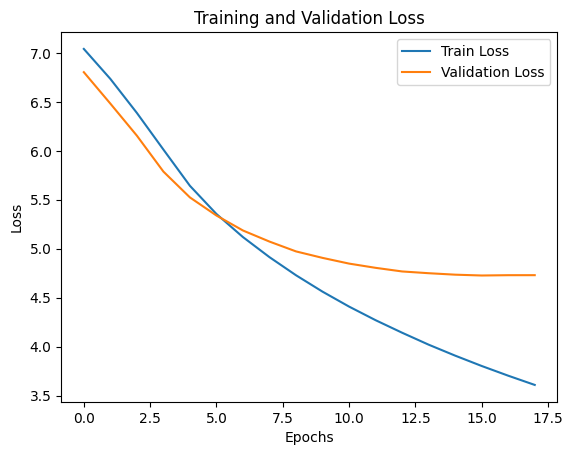

In [ ]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

validation loss가 감소하는 경향이 없어졌으므로 20 epoch에서 early stop  
(1차 시도에서 했던 그래프임)

# 7. 인퍼런스 모델 구현

In [41]:
src_index_to_word = {idx: word for word, idx in src_vocab.items()} # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_vocab # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()} # 요약 단어 집합에서 정수 -> 단어를 얻음

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# 인코더 설계
def encode_input(encoder, input_seq):
    encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

# 이전 시점의 상태들을 저장하는 텐서
num_layers = 3  # 디코더 LSTM 레이어 개수 (설정에 맞춰 조정)
batch_size = 1

decoder_state_input_h = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_state_input_c = torch.zeros((num_layers, batch_size, hidden_size), dtype=torch.float, device=device)
decoder_input = torch.zeros((batch_size, 1), dtype=torch.long, device=device)

dec_emb2 = decoder.embedding(decoder_input)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder(decoder_input, decoder_state_input_h, decoder_state_input_c)

In [42]:
class DecoderWithAttention(nn.Module):
    def __init__(self, decoder, attention, hidden_size, vocab_size):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 기존 디코더
        self.attention = attention  # 어텐션 레이어
        self.concat = nn.Linear(hidden_size * 2, hidden_size)  # 어텐션 결합 레이어
        self.output_layer = nn.Linear(hidden_size, vocab_size)  # 최종 출력층
        self.softmax = nn.Softmax(dim=-1)  # 소프트맥스

    def forward(self, decoder_inputs, decoder_hidden_state, decoder_state_h, decoder_state_c):
        # 디코더 실행
        decoder_outputs, state_h, state_c = self.decoder(decoder_inputs, decoder_state_h, decoder_state_c)

        # 어텐션 적용
        attn_out = self.attention(decoder_outputs, decoder_hidden_state)

        # 어텐션과 디코더 출력 결합
        decoder_concat_output = torch.cat((decoder_outputs, attn_out), dim=-1)
        decoder_concat_output = torch.tanh(self.concat(decoder_concat_output))

        # 최종 출력층 적용
        decoder_outputs2 = self.softmax(self.output_layer(decoder_concat_output))

        return decoder_outputs2, state_h, state_c

# 기존 Attention 클래스 사용
attention_layer = Attention_dot(hidden_size)

# 디코더 모델 생성
decoder_model = DecoderWithAttention(decoder, attention_layer, hidden_size, tar_vocab_size)

In [43]:
def decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, text_max_len, summary_max_len, device):
    # 입력을 PyTorch Tensor로 변환
    input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)

    # 인코더 실행하여 초기 상태(hidden, cell) 얻기
    with torch.no_grad():
        e_out, e_h, e_c = model.encoder(input_seq)

    e_out = e_out.repeat(1, text_max_len, 1)  # 차원 조정 (np.tile 대신 repeat 사용)

    # <SOS>에 해당하는 토큰 생성
    target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # 디코더 실행
        with torch.no_grad():
            output_tokens, h, c = model.decoder(target_seq, e_h, e_c)

        # 가장 높은 확률을 가진 단어 선택
        sampled_token_index = torch.argmax(output_tokens[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <eos>에 도달하거나 최대 길이를 초과하면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = torch.zeros((1, 1), dtype=torch.long, device=device)
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

# 7. 모델 테스트

In [44]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0:  # 패딩(0) 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        key = int(i.item())  # PyTorch Tensor → int 변환
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '  # 안전한 조회
    return temp.strip()  # 양쪽 공백 제거

In [45]:
%%time
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2summary(decoder_input_test[i]))
    input_seq = torch.tensor(encoder_input_test[i], dtype=torch.long, device=device).unsqueeze(0)
    print("예측 헤드라인 :", decode_sequence(input_seq, model, tar_word_to_index, tar_index_to_word, text_max_len, headlines_max_len, device))
    print("\n")

원문 : least three people including two teenagers killed friday plane crash landed summer camp switzerland four seat aircraft crashed <UNK> region around minutes take authorities said group tourists taken <UNK> ride explore region peaks witnessed plane crash ground
실제 헤드라인 : three killed in swiss youth camp flight crash
예측 헤드라인 :  fire woman takes cm takes her his his his


원문 : addressing party workers uttar pradesh gorakhpur state chief minister yogi adityanath monday said caste based politics wins development defeated adding casteism solution problem chief minister said development ensured people ideology work district level state level central level
실제 헤드라인 : if caste politics wins development will be defeated yogi
예측 헤드라인 :  facebook facebook facebook facebook school bn bn shares shares


원문 : reacting us president donald trump looking directly sun without safety glasses august total solar eclipse user tweeted solar eclipse fake news another tweet read aide need wear eclipse glasses

<timed exec>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
/tmp/ipython-input-1019732637.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq = torch.tensor(input_seq, dtype=torch.long, device=device)


예측 헤드라인 :  while deal security its cm cm with google dies


원문 : bollywood writer <UNK> <UNK> wrote story shashi kapoor starrer jab jab phool <UNK> passed away thursday evening battling cancer suffering <UNK> cancer admitted shanti <UNK> ashram said writer director anusha srinivasan iyer written script tv serial <UNK> directed neena gupta
실제 헤드라인 : wood writer <UNK> <UNK> passes away after <UNK> cancer
예측 헤드라인 :  st woman woman woman yrs yrs wins that team


원문 : police thursday arrested people including five women thailand alleged involvement sex racket following raid spa gurugram sector market fir registered spa owner absconding police officials said however spa manager <UNK> arrested raid
실제 헤드라인 : police raid gurugram <UNK> arrest over sex trade racket
예측 헤드라인 :  becomes its its its fake actor actor months bn


원문 : makers amul ice creams told bombay high court thursday company compares product rival advertisement <UNK> inevitable comes hul maker <UNK> wall frozen desserts accused 

실제와 예측 문장을 대조해보니 전혀 다른 문장이 나왔고, 문법도 알아볼 수 없는 모습이다.

# 8. 추출적 요약

In [ ]:
!pip install summa

In [ ]:
# 데이터 다운로드

import requests
from summa.summarizer import summarize

url = "https://raw.githubusercontent.com/modulabs/Aiffel_Resources/main/matrix_synopsis.txt"
text = requests.get(url, timeout=10).text
print(text[:1500])

In 1999, in an unnamed city, Computer programmer Thomas Anderson (Keanu Reeves) is secretly a hacker known as "Neo". He is restless, eager and driven to learn the meaning of cryptic references to the "Matrix" appearing on his computer. A woman named Trinity is observing Neo, and she does so knowing that Morpheus believes that Neo is "the One".

During one of her forays, Trinity is tracked down by the local police to her hotel room. Outside the hotel a car drives up and three agents appear in neatly pressed black suits. They are Agent Smith (Hugo Weaving), Agent Brown (Paul Goddard), and Agent Jones (Robert Taylor). Trinity calls Morpheus and says that her line was tracked and Morpheus orders her to find another exit. Trinity easily defeats the six policemen sent to apprehend her, using fighting and evasion techniques that seem to defy gravity.

A fierce rooftop chase ensues with Trinity and an Agent leaping impossibly from one building to the next, astonishing the policemen left behind

## 8.1. summarize 사용

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.01))

Summary:
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


In [ ]:
print('Summary:')
print(summarize(text, ratio=0.01, split=True))

Summary:
['Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.']


In [ ]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


| 요약 방식 | 문법 완성도 | 핵심단어 포함 |
| :--- | :--- | :--- |
| **추상적 요약 (Abstractive)**<br/>(Seq2Seq + Attention 모델) | **실패**<br/>문법적으로 완전히 틀리고 의미가 없는 단어의 나열이 생성됨. | **실패**<br/>원문의 핵심 단어를 전혀 포함하지 못하고 대신 훈련 데이터에서 잘못 학습된 것으로 보이는 단어만 반복적으로 생성. |
| **추출적 요약 (Extractive)**<br/>(Summa 라이브러리) | **성공**<br/>  원문에서 문법적으로 완벽한 문장을 그대로 추출. | **성공**<br/> 원문의 핵심 단어가 포함된 핵심 문장을 성공적으로 찾아냄. |

추상적 요약 모델은 실패했다.